In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)


In [32]:
periodNum = 0
threshold = 2
previousDeviceId = 0
previousDirection = 1 # either -1, 1

def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'screen_on']
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

def nextPeriod() :
    global periodNum
    periodNum = periodNum + 1
    return periodNum

def resetPeriods() :
    global periodNum
    periodNum = 0

In [5]:
df = prepare('datasets/samples.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11503813 entries, 0 to 11503812
Data columns (total 5 columns):
device_id         uint16
timestamp         datetime64[ns]
battery_level     uint8
network_status    object
screen_on         uint8
dtypes: datetime64[ns](1), object(1), uint16(1), uint8(2)
memory usage: 219.4+ MB


In [6]:
df['change'] = df.battery_level - df.battery_level.shift()
df.loc[df.device_id != df.device_id.shift(), 'change'] = None

In [7]:
def show_hist(s, bins, title, end=None, start=0, step=1, ylabel='# Samples', color='#66b3ff'):
    s.hist(bins=bins, color=color, edgecolor='k', linewidth=.5, figsize=(12,6))
    if (end != None):
        plt.xticks(np.arange(start, end, step))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()

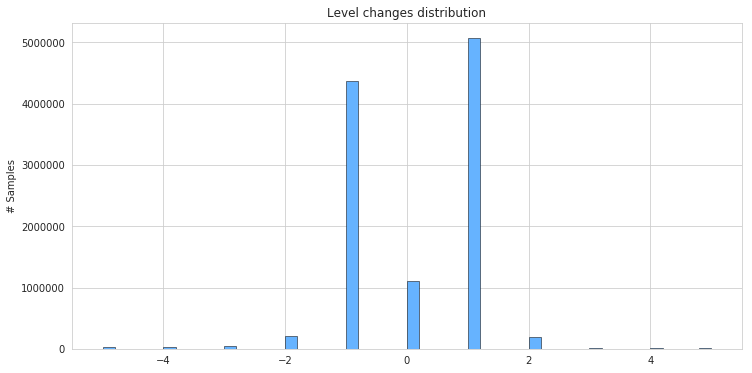

In [8]:
interval = 5

gl = df[(df['change'] >= -interval) & (df['change'] <= interval)]

show_hist(gl['change'], 50, 'Level changes distribution')

In [9]:
df['change_acc'] = df['change'].cumsum()
df.loc[df.device_id != df.device_id.shift(), 'change_acc'] = None

In [45]:
#temporary df to test
df2 = df
df2['period'] = 1

In [46]:






sign = lambda x: x and (1, -1)[x < 0]

def calculatePeriod(deviceId, change) : 
    
    hardCodedDirection = -1
    
    currentDeviceId = deviceId
    directionChanged = False
    global previousDeviceId 
    global previousDirection
    
    if( pd.isnull(change)) : #if first sample of device, need to initialize directions
        previousDirection = hardCodedDirection
        currentDirection = previousDirection
    else :
        currentDirection = sign(change)
        
    if (currentDirection != 0) : # either -1, 1 = the battery changed. if 0, then we keep the previousDirection
        if (currentDirection != previousDirection) : # the battery changed direction, else nothing changes
            directionChanged = True 
            previousDirection = currentDirection
    
    if((deviceId == previousDeviceId) #same device
       and (change >= -threshold) and (change <= threshold) #within threshold
       and (not directionChanged)) : #direction not changed
        return periodNum
    else :
        previousDeviceId = deviceId
        return nextPeriod()

resetPeriods()
df2['period'] = df2.apply(lambda row : calculatePeriod(row['device_id'], row['change']), axis = 1)


df2


,device_id,timestamp,battery_level,network_status,screen_on,change,change_acc,period
0,1,2017-10-15 18:36:46,99,lte,1,NaN,NaN,1
1,1,2017-10-15 18:41:54,98,lte,1,-1.0,-1.0,1
2,1,2017-10-15 18:46:54,97,lte,1,-1.0,-2.0,1
3,1,2017-10-15 18:50:35,96,lte,1,-1.0,-3.0,1
4,1,2017-10-15 18:54:14,95,lte,1,-1.0,-4.0,1
5,1,2017-10-15 18:54:14,95,lte,1,0.0,-4.0,1
6,1,2017-10-15 18:57:54,94,lte,1,-1.0,-5.0,1
7,1,2017-10-15 19:02:47,93,lte,1,-1.0,-6.0,1
8,1,2017-10-15 19:11:41,91,lte,1,-2.0,-8.0,1
9,1,2017-10-15 19:21:25,89,lte,1,-2.0,-10.0,1


In [21]:
#df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
#df['time_acc'] = df['time_diff'].cumsum()
#df.loc[df.device_id != df.device_id.shift(), 'time_acc'] = None

In [52]:
df2.groupby(['period'])['period'].count().agg([pd.np.min,pd.np.max,pd.np.mean])

amin       1.000000
amax    1604.000000
mean       9.761378
Name: period, dtype: float64

In [53]:
df2.groupby(['period'])['period'].count()

period
1          11
2          49
3           7
4          47
5          11
6          32
7           4
8           4
9           5
10          8
11          9
12          9
13         15
14         12
15         62
16         59
17          3
18          2
19         51
20         39
21         12
22         40
23         37
24         12
25          9
26          4
27         44
28         21
29          6
30          4
           ..
1178474     9
1178475     1
1178476     1
1178477     1
1178478     1
1178479     1
1178480     2
1178481     4
1178482     1
1178483    12
1178484    20
1178485     7
1178486     1
1178487     1
1178488     4
1178489     7
1178490    20
1178491     1
1178492     5
1178493     2
1178494    70
1178495    50
1178496    12
1178497    12
1178498     7
1178499    21
1178500     2
1178501     1
1178502    31
1178503    48
Name: period, Length: 1178503, dtype: int64

In [77]:
df3 = df2.groupby(['period'])['period'].count().reset_index(name="count")
df3.sort_values(by=['count'], ascending=False)
df4 = df3.groupby(['count'])['count'].count()
df4

count
1       508817
2       133887
3        74007
4        49174
5        37278
6        30082
7        24967
8        21861
9        18487
10       16479
11       14590
12       13311
13       12302
14       10957
15       10303
16        9401
17        8738
18        8154
19        7468
20        7086
21        6301
22        5881
23        5681
24        5242
25        4959
26        4653
27        4528
28        4226
29        4074
30        3842
         ...  
407          1
410          1
413          1
416          1
423          1
432          1
438          1
440          1
452          2
454          1
466          1
480          1
520          1
524          1
533          1
540          1
563          1
567          1
589          1
610          1
641          1
695          1
723          1
765          1
925          1
998          1
1071         1
1166         1
1358         1
1604         1
Name: count, Length: 330, dtype: int64

In [75]:
df2.loc[df['period'] == 778962]

,device_id,timestamp,battery_level,network_status,screen_on,change,change_acc,period
7701495,13047,2018-11-05 00:31:42,31,disconnected,0,1.0,21000.0,778962
7701496,13047,2018-11-05 00:34:44,32,lte,0,1.0,21001.0,778962
7701497,13047,2018-11-05 00:37:24,33,lte,1,1.0,21002.0,778962
7701498,13047,2018-11-05 00:41:31,34,wifi,0,1.0,21003.0,778962
7701499,13047,2018-11-05 00:41:38,34,wifi,0,0.0,21003.0,778962
7701500,13047,2018-11-05 00:41:39,34,wifi,0,0.0,21003.0,778962
7701501,13047,2018-11-05 00:41:59,34,wifi,0,0.0,21003.0,778962
7701502,13047,2018-11-05 00:42:02,34,wifi,0,0.0,21003.0,778962
7701503,13047,2018-11-05 00:42:07,34,wifi,0,0.0,21003.0,778962
7701504,13047,2018-11-05 00:42:25,34,wifi,0,0.0,21003.0,778962
